# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [1]:
from azureml.core import Workspace, Experiment

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core import Dataset

#import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from azureml.train.automl import AutoMLConfig

from azureml.widgets import RunDetails

from azureml.core import Model

import joblib

from azureml.core.webservice import AciWebservice, Webservice

## Dataset

### Overview
Dataset that will be used is Iris dataset available in UCI machine learining repository. Dataset is explored in cells below, after it is downloaded. Classification experiment will be done.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [15]:
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="capstone")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EESXBN2EC to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: quick-starts-ws-138730
Azure region: southcentralus
Subscription id: 510b94ba-e453-4417-988b-fbdc37b55ca7
Resource group: aml-quickstarts-138730


In [16]:
cpu_cluster_name = "udacity-project3"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [8]:
#train_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/train.csv'
#test_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/test.csv'
#data_train = Dataset.Tabular.from_delimited_files(path=train_link)
#data_test = Dataset.Tabular.from_delimited_files(path=test_link)

data='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
dataset = Dataset.Tabular.from_delimited_files(data, header=False )

train, test = dataset.random_split(percentage=0.8, seed=42)

dataset=dataset.to_pandas_dataframe()
dataset.columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'iris_class']
#test = data_test.to_pandas_dataframe()

#dataset = dataset.append(test)

print(dataset.size)
dataset.head()

750


,sepal_length,sepal_width,petal_length,petal_width,iris_class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [9]:
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


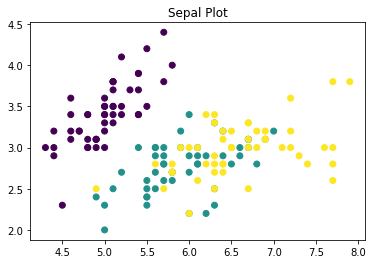

In [10]:
plt.title("Sepal Plot")
plt.scatter('sepal_length', 'sepal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

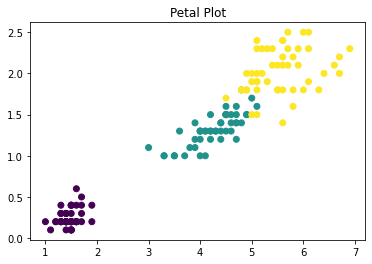

In [11]:
plt.title("Petal Plot")
plt.scatter('petal_length', 'petal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

In [12]:
dataset.size

750

## AutoML Configuration

Task is classification as we try to predict iris class. Timeout is set to 15 mins as the data is pretty straightforward. Primary metric is accuracy as data is well balanced and therfore this metric will provide correct results. Train data constitutes 80% of total data, rest is holded for validation. Cross validations are set to 5 as dataset is pretty small.

In [17]:
# TODO: Put your automl settings here
automl_settings = {
    'experiment_timeout_minutes': 15,
    'primary_metric' : 'accuracy',
    'n_cross_validations': 5
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=cpu_cluster,
                             task = "classification",
                             training_data=train,
                             label_column_name='Column5', 
                             enable_early_stopping= True,
                             experiment_timeout_minutes= 15,
                             primary_metric = 'accuracy',
                             n_cross_validations= 5
                            )

In [18]:
# TODO: Submit your experiment
remote_run = exp.submit(automl_config, show_output=True)
RunDetails(remote_run).show()

Running on remote.
No run_configuration provided, running on udacity-project3 with default configuration
Running on remote compute: udacity-project3
Parent Run ID: AutoML_dbbf5631-f3a9-4e0c-8850-0bce8ab44f38

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Run Details

Ensemble model, Voting Classifier returned best results. This type of models tend to preform well on such tasks as they combine predictions of many different models in order to improve robustness over a single estimator. 

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [19]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [12]:
remote_run.wait_for_completion(show_output=True)



****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more abo

{'runId': 'AutoML_d8c62d0e-691f-4a37-9165-3618937af3e8',
 'target': 'udacity-project3',
 'status': 'Completed',
 'startTimeUtc': '2021-02-10T19:21:46.828002Z',
 'endTimeUtc': '2021-02-10T19:49:32.846214Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'udacity-project3',
  'AMLSettingsJsonString': '{"path":null,"name":"capstone","subscription_id":"610d6e37-4747-4a20-80eb-3aad70a55f43","resource_group":"aml-quickstarts-138433","workspace_name":"quick-starts-ws-138433","region":"southcentralus","compute_target":"udacity-project3","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"num_classe

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [20]:
best_run, best_model = remote_run.get_output()
best_run_metrics = best_run.get_metrics()

best_run

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


Experiment,Id,Type,Status,Details Page,Docs Page
capstone,AutoML_dbbf5631-f3a9-4e0c-8850-0bce8ab44f38_13,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [21]:
best_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=None,
                                                                  enable_feature_sweeping=None,
                                                                  feature_sweeping_config=None,
                                                                  feature_sweeping_timeout=None,
                                                                  featurization_config=None,
                                                                  force_text_dnn=None,
                                                                  is_cross_validation=None,
                                                                  is_onnx_compatible=None,
                                                                  logger=None,
                                                              

In [22]:
print('Best Run Id: ', best_run.id)
print('Accuracy:', best_run_metrics['accuracy'])
print(best_model._final_estimator)

Best Run Id:  AutoML_dbbf5631-f3a9-4e0c-8850-0bce8ab44f38_13
Accuracy: 0.984
PreFittedSoftVotingClassifier(classification_labels=None,
                              estimators=[('9',
                                           Pipeline(memory=None,
                                                    steps=[('sparsenormalizer',
                                                            <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7fd2e3d99240>),
                                                           ('lightgbmclassifier',
                                                            LightGBMClassifier(boosting_type='goss',
                                                                               class_weight=None,
                                                                               colsample_bytree=0.5944444444444444,
                                                                               importance_type='split',
                    

In [23]:
#TODO: Save the best model
os.makedirs('./outputs', exist_ok=True)

joblib.dump(best_model, filename='outputs/automl.joblib')

model_name = best_run.properties['model_name']
print(model_name)

AutoMLdbbf5631f13


## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

Hyperdrive run returned better results and it was deployed.

EDIT: Since the reviewer requested to register this as well, then it is registered below:

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [24]:
model = remote_run.register_model(model_name=model_name, description='AML_reg')

In [25]:
model

Model(workspace=Workspace.create(name='quick-starts-ws-138730', subscription_id='510b94ba-e453-4417-988b-fbdc37b55ca7', resource_group='aml-quickstarts-138730'), name=AutoMLdbbf5631f13, id=AutoMLdbbf5631f13:1, version=1, tags={}, properties={})

In [27]:
!conda list > packages.txt